<a href="https://colab.research.google.com/github/DayrisRM/VisionArtificial-M1/blob/main/VGG16_US_ROI_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving US_ROI_dataset_final.zip to US_ROI_dataset_final.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['US_ROI_dataset_final.zip']), 'r')
data.extractall()

In [3]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from matplotlib import pyplot
from keras.callbacks import EarlyStopping


In [5]:
# define cnn model
def define_model():
  # load model
  model = VGG16(include_top=False, input_shape=(224, 224, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  
  last_layer = model.get_layer('block5_pool')
  last_output = last_layer.output
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(model.input, x)  

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [6]:
model = define_model()
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [7]:
#functions to build confusion matrix
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

IMG_SIZE = (224,224)
X_val, y_val, labels = load_data('US_ROI_dataset_final/validation/', IMG_SIZE)
print(labels)

100%|██████████| 2/2 [00:00<00:00, 68.01it/s]

25 images loaded from US_ROI_dataset_final/validation/ directory.
{0: 'Benign', 1: 'Malignant'}


In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  pyplot.figure(0)
  pyplot.title('Cross Entropy Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.legend(['loss','val_loss']) 

  # plot accuracy
  pyplot.figure(1)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
  pyplot.legend(['accuracy','val_accuracy'])
  
  # save and show plot to file
  pyplot.savefig('metrics_plot.png')
  pyplot.show()

In [9]:
def validateOnValSet(model):  
  predictions = model.predict(X_val) 
  predictions = [1 if x>0.5 else 0 for x in predictions]  
  accuracy = accuracy_score(y_val, predictions)  
  print('Val Accuracy on validation set = %.2f' % accuracy)
  confusion_mtx = confusion_matrix(y_val, predictions)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False) 


In [10]:
# run the test harness for evaluating a model
def run_test_harness():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1./255)
  # prepare iterator
  train_it = datagen.flow_from_directory('US_ROI_dataset_final/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
  test_it = datagen.flow_from_directory('US_ROI_dataset_final/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
  #callback
  #es = EarlyStopping(monitor='accuracy', patience=8, mode='max', verbose=1)
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=60, verbose=1)
  # evaluate model
  loss, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
  print('acc > %.3f' % (acc * 100.0))
  print("loss : ", loss)    
  # learning curves
  summarize_diagnostics(history)
  validateOnValSet(model)

  # save model
  #model.save('final_model.h5')

Found 98 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/60
2/2 [==============================] - 22s 6s/step - loss: 0.7660 - accuracy: 0.5612 - val_loss: 0.6557 - val_accuracy: 0.6500
Epoch 2/60
2/2 [==============================] - 1s 552ms/step - loss: 0.6382 - accuracy: 0.6837 - val_loss: 0.7163 - val_accuracy: 0.6500
Epoch 3/60
2/2 [==============================] - 1s 454ms/step - loss: 0.6036 - accuracy: 0.7041 - val_loss: 0.5289 - val_accuracy: 0.7000
Epoch 4/60
2/2 [==============================] - 1s 463ms/step - loss: 0.5478 - accuracy: 0.7245 - val_loss: 0.5150 - val_accuracy: 0.7500
Epoch 5/60
2/2 [==============================] - 1s 549ms/step - loss: 0.5272 - accuracy: 0.7245 - val_loss: 0.4859 - val_accuracy: 0.7750
Epoch 6/60
2/2 [==============================] - 1s 554ms/step - loss: 0.4803 - accuracy: 0.7755 - val_loss: 0.5412 - val_accuracy: 0.7250
Epoch 7/60
2/2 [==============================] - 1s 551ms/step - loss: 0.5602 - a

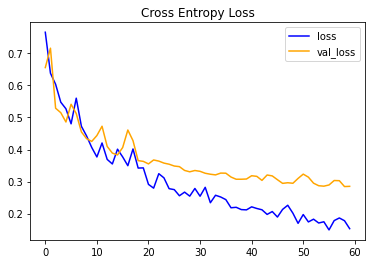

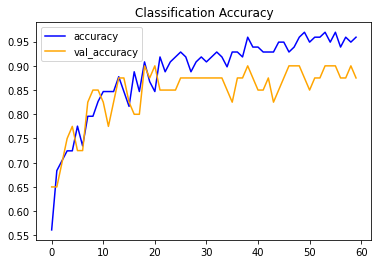

Val Accuracy on validation set = 0.72


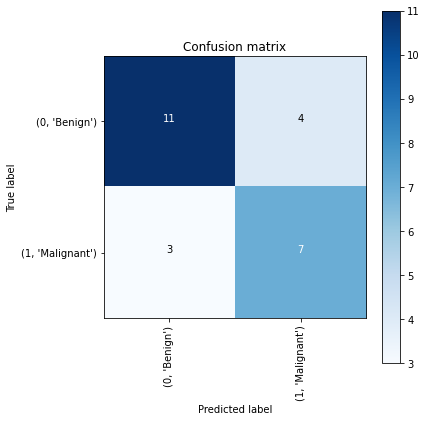

In [11]:
# entry point, run the test harness
run_test_harness()